# Common imports

In [ ]:
#!pip install scikit-learn
#!pip install scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm

In [2]:
# Fix randomness
rng = np.random.default_rng(42)

# Batch normalization

In [3]:
import scipy.stats

In [4]:
# Let's create some distributions
# We will use scipy.stats to create distributions
# https://docs.scipy.org/doc/scipy/reference/stats.html

x = torch.FloatTensor(
    np.column_stack(
        [
            scipy.stats.dweibull.rvs(c=2.07, size=10000) * np.random.randint(5000),
            scipy.stats.kappa4.rvs(0.1, 0, size=10000) * np.random.randint(5000),
            scipy.stats.laplace.rvs(size=10000) * np.random.randint(5000),
            scipy.stats.maxwell.rvs(size=10000) * np.random.randint(5000),
            scipy.stats.halfnorm.rvs(size=10000) * np.random.randint(5000),
        ]
    )
)

In [5]:
print("Shape of x:", x.shape)

Shape of x: torch.Size([10000, 5])


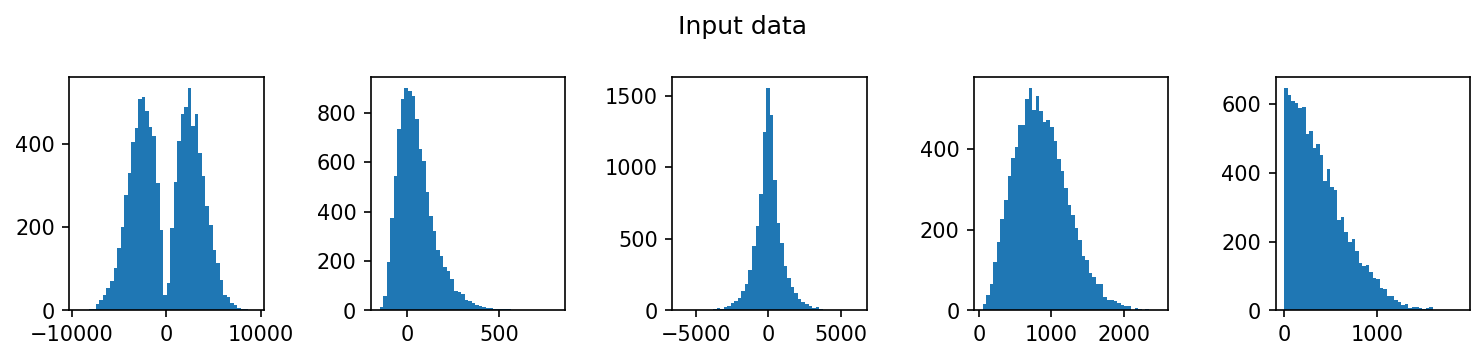

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5 * (8 / 5)), dpi=150)

for column_i in range(5):
    ax[column_i].hist(x[:, column_i].data.numpy(), bins=50, label="Original")
fig.suptitle("Input data")
plt.tight_layout()
plt.show()

In [6]:
layer = nn.Linear(5, 5)

transformed_x = layer(x)

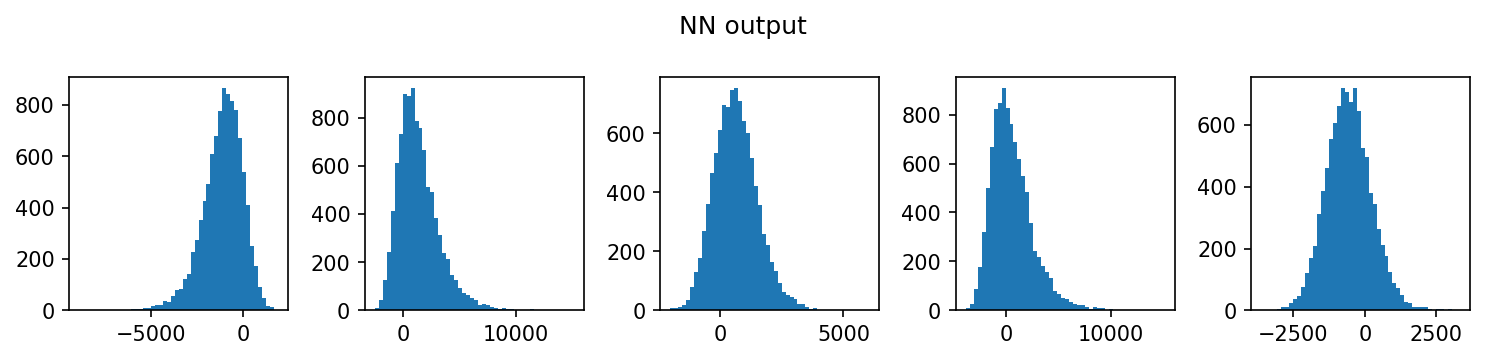

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5 * (8 / 5)), dpi=150)

for column_i in range(5):
    ax[column_i].hist(
        transformed_x[:, column_i].data.numpy(), bins=50, label="Original"
    )
fig.suptitle("NN output")
plt.tight_layout()
plt.show()

### Normalization (manual)

In [8]:
x_normalized = (x - torch.mean(x, 0)) / torch.std(x, 0)

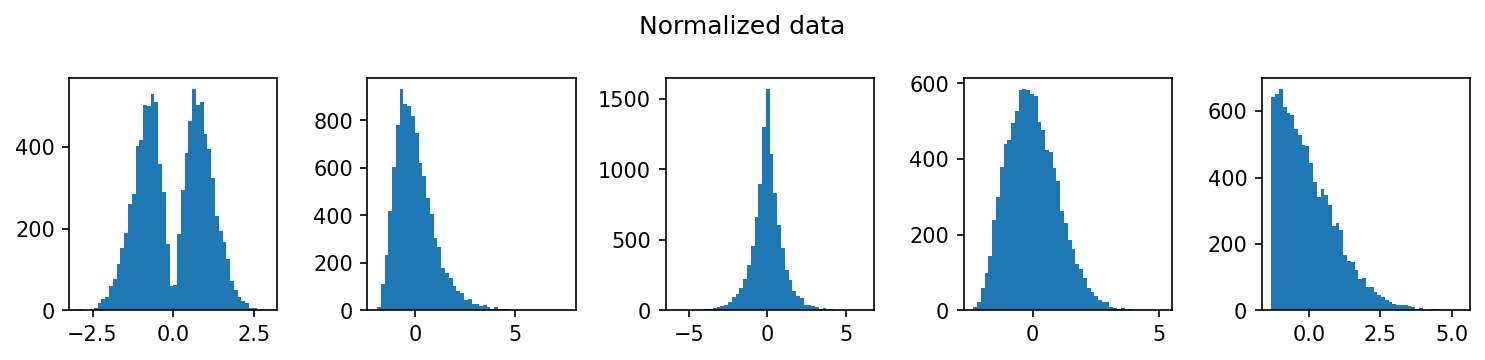

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5 * (8 / 5)), dpi=150)

for column_i in range(5):
    ax[column_i].hist(
        x_normalized[:, column_i].data.numpy(), bins=50, label="Normalized"
    )
fig.suptitle("Normalized data")
plt.tight_layout()
plt.show()

In [10]:
transformed_x_normalized = layer(x_normalized)

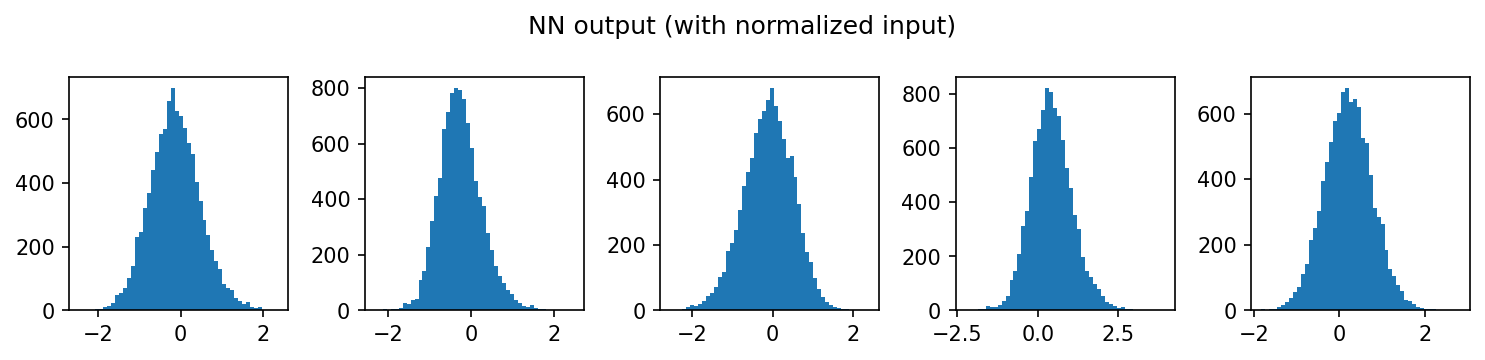

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5 * (8 / 5)), dpi=150)

for column_i in range(5):
    ax[column_i].hist(
        transformed_x_normalized[:, column_i].data.numpy(), bins=50, label="Normalized"
    )
fig.suptitle("NN output (with normalized input)")
plt.tight_layout()
plt.show()

## BatchNorm1d
$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

Where $\gamma$ and $\beta$ are learnable parameters (if `affine=True`).\
$\mathrm{E}[x]$ and $\mathrm{Var}[x]$ are estimated via the current batch during the training phase.\
During the test phase, they are estimated via an exponential moving average of the entire training set.

In [13]:
# Create a batchnorm layer
bn = nn.BatchNorm1d(5, affine=True)

In [14]:
# Apply batchnorm to x
bn_output = bn(x)

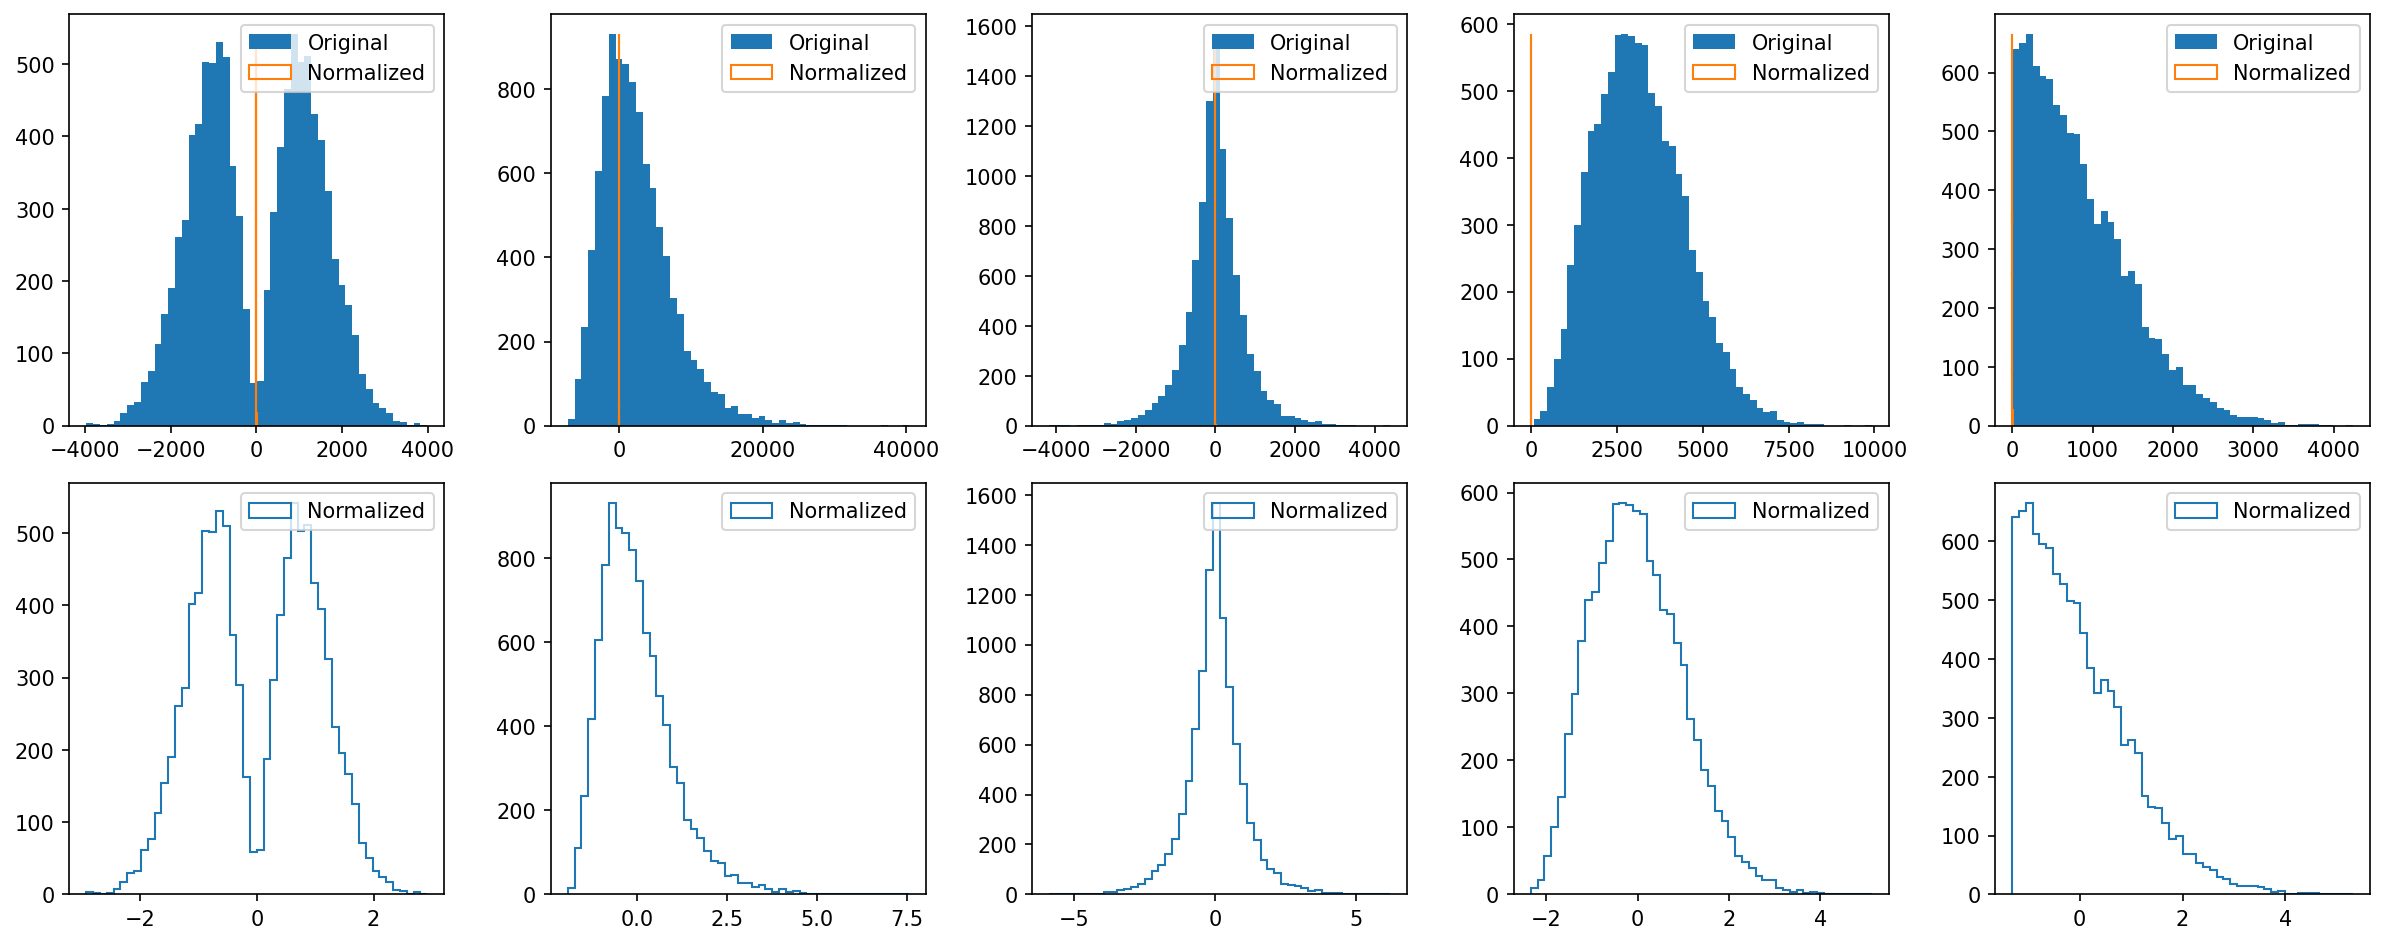

In [15]:
# Plot the distributions and the batchnorm results
fig, ax = plt.subplots(2, 5, figsize=(16, 2 * (16 / 5)), dpi=150)

for column_i in range(5):
    ax[0][column_i].hist(x[:, column_i].data.numpy(), bins=50, label="Original")
    ax[0][column_i].hist(
        bn_output[:, column_i].data.numpy(),
        bins=50,
        histtype="step",
        label="Normalized",
    )
    ax[1][column_i].hist(
        bn_output[:, column_i].data.numpy(),
        bins=50,
        histtype="step",
        label="Normalized",
    )
    ax[0][column_i].legend()
    ax[1][column_i].legend()

plt.tight_layout()
plt.show()

In [16]:
# During the training phase, batchnorm normalizes the data using the batch mean and variance
# During the testing phase, batchnorm normalizes the data using the running mean and variance
# This is why we need to call model.eval() before testing
print("Training mode")
print(bn.training)
print("Running mean")
print(bn.running_mean)
print("Running variance")
print(bn.running_var)

Training mode
True
Running mean
tensor([1.3652e+00, 2.4780e+02, 2.7565e-01, 3.1642e+02, 8.4038e+01])
Running variance
tensor([ 185252.7188, 2517960.0000,   50079.5508,  173475.0938,   40961.8633])


In [17]:
# We have 2N learnable parameters (if affine=True)
print("Number of parameters")
for p in bn.parameters():
    print(p)

Number of parameters
Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


## Let's train something

### Create a dataset

In [18]:
# Create random matrix
A_size = 10

A = rng.normal(0, 1, size=(A_size, A_size))

In [19]:
# Create a simple dataset
N_points = 1000
batch_size = 1000

data_x = rng.normal(0, 1, size=(N_points, A_size))
data_y = np.array([np.matmul(A, x) for x in data_x])

In [20]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42
)

In [21]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define network

In [24]:
class Net(nn.Module):
    def __init__(self, input_size, layer_sizes, use_bn=False):
        super(Net, self).__init__()

        self.use_batch_norm = use_bn

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        self.layer1 = nn.Linear(input_size, layer_sizes[0])
        for hidden_i in range(1, len(layer_sizes)):
            use_bias = True
            # If we use a batchnorm, we don't need a bias term (already included in the batchnorm)
            if use_bn:
                use_bias = False
            self.layers.append(
                nn.Linear(
                    layer_sizes[hidden_i - 1], layer_sizes[hidden_i], bias=use_bias
                )
            )
        self.layer2 = nn.Linear(layer_sizes[-1], input_size)

        if use_bn:
            for hidden_i in range(1, len(layer_sizes)):
                self.bn_layers.append(nn.BatchNorm1d(layer_sizes[hidden_i]))

    def forward(self, x):

        out = self.layer1(x)

        for hidden_i, layer in enumerate(self.layers):
            out = layer(out)
            if self.use_batch_norm:
                out = self.bn_layers[hidden_i](out)

        out = self.layer2(out)
        return out

In [25]:
net = Net(10, [20] * 23)
net_with_bn = Net(10, [20] * 23, True)

In [26]:
loss_func = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
opt_with_bn = torch.optim.Adam(net_with_bn.parameters(), lr=1e-4)

In [27]:
def train_one_epoch(net, optimizer, dataloader):
    batch_losses = []
    net.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        output = net(x)
        loss = loss_func(output, y)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return np.mean(batch_losses)


def test_loss(net, dataloader):
    val_losses = []
    net.eval()
    for x, y in dataloader:
        output = net(x)
        loss = loss_func(output, y)
        val_losses.append(loss.item())
    return np.mean(val_losses)

In [28]:
loss_vs_epoch = []
loss_vs_epoch_with_bn = []
n_epochs = 1000

for epoch in tqdm(range(n_epochs)):
    loss_vs_epoch.append(
        [train_one_epoch(net, opt, train_dataloader), test_loss(net, test_dataloader)]
    )
    loss_vs_epoch_with_bn.append(
        [
            train_one_epoch(net_with_bn, opt_with_bn, train_dataloader),
            test_loss(net_with_bn, test_dataloader),
        ]
    )

100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


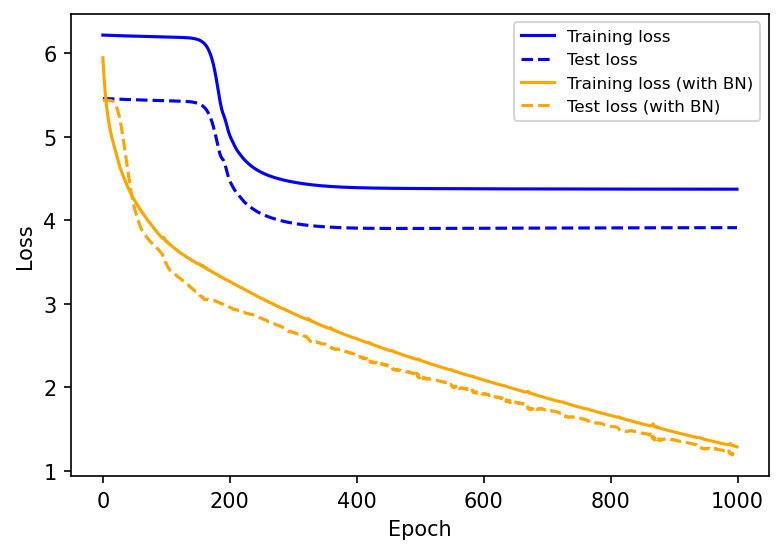

In [26]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

loss_vs_epoch = np.array(loss_vs_epoch)
loss_vs_epoch_with_bn = np.array(loss_vs_epoch_with_bn)

ax.plot(loss_vs_epoch[:, 0], label="Training loss", c="blue")
ax.plot(loss_vs_epoch[:, 1], label="Test loss", c="blue", linestyle="--")
ax.plot(loss_vs_epoch_with_bn[:, 0], label="Training loss (with BN)", c="orange")
ax.plot(
    loss_vs_epoch_with_bn[:, 1], label="Test loss (with BN)", c="orange", linestyle="--"
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=8)

plt.show()

## Limitations of BatchNorm
- If batch size is too small, the estimated mean and variance will be inaccurate.
- Not suitable for sequence models. (e.g. RNNs) -> **Solution: Layer normalization**

## Other types of normaliztion

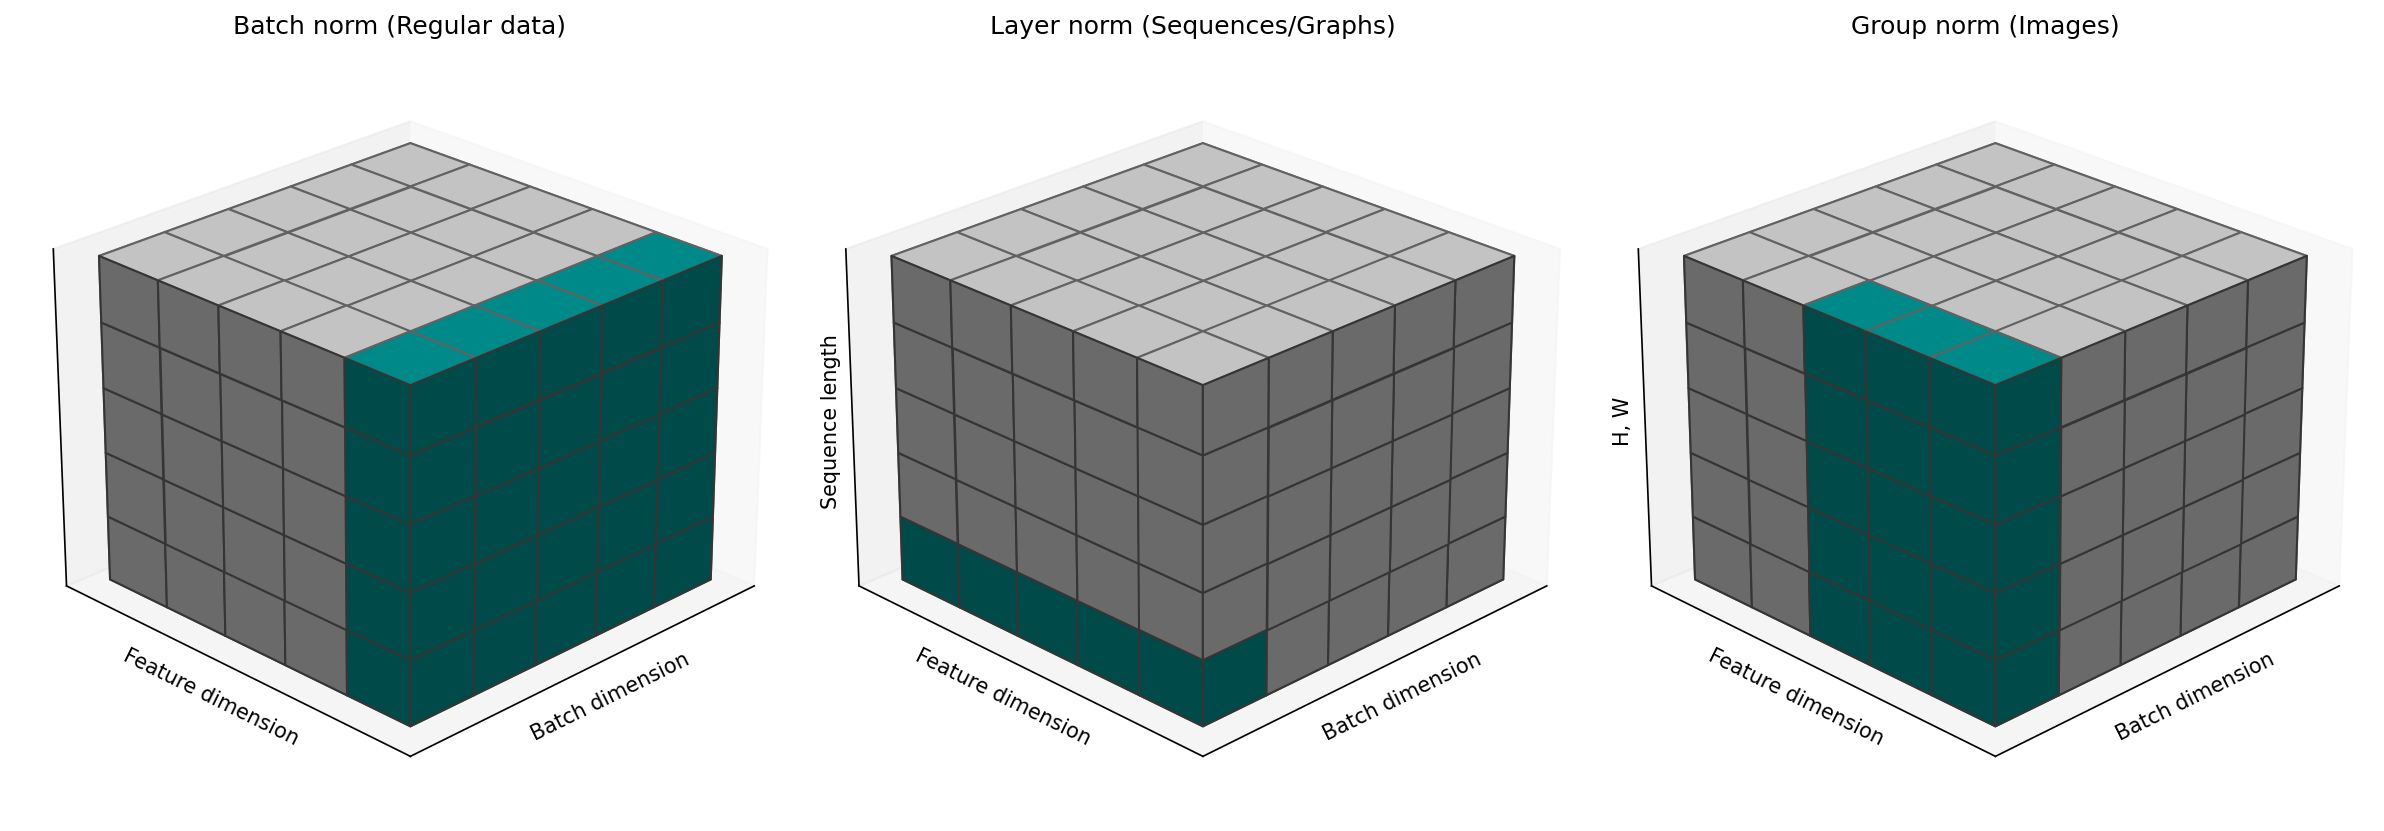

In [27]:
def plot_cube(
    ax,
    title,
    colors,
    xlabel="Batch dimension",
    ylabel="Feature dimension",
    zlabel="Sequence length",
):
    ax.set_title(title)
    ax.voxels(data, facecolors=colors, edgecolors="gray")
    ax.view_init(25, 45)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("Batch dimension")
    ax.set_ylabel("Feature dimension")
    ax.set_zlabel(zlabel, rotation=90)
    ax.xaxis.labelpad = -10
    ax.yaxis.labelpad = -10
    ax.zaxis.labelpad = -15
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


# Create axis
axes = [5, 5, 5]
# Create Data
data = np.ones(axes)
# Control Transparency
alpha = 1

# Plot figure
fig = plt.figure(figsize=(16, 8), dpi=150)
ax = fig.add_subplot(131, projection="3d")
colors = np.ones(axes + [4], dtype=np.float32)
colors[:, -1] = [0, 0.7, 0.7, alpha]
plot_cube(ax, "Batch norm (Regular data)", colors, zlabel=None)

ax = fig.add_subplot(132, projection="3d")
colors = np.ones(axes + [4], dtype=np.float32)
colors[-1, :, 0] = [0, 0.7, 0.7, alpha]
plot_cube(ax, "Layer norm (Sequences/Graphs)", colors)

ax = fig.add_subplot(133, projection="3d")
colors = np.ones(axes + [4], dtype=np.float32)
colors[-1, 2:] = [0, 0.7, 0.7, alpha]
plot_cube(ax, "Group norm (Images)", colors, ylabel="Channels", zlabel="H, W")

plt.tight_layout()
plt.show()

### Links to papers
- [Batch normalization](https://arxiv.org/abs/1502.03167)
- [Layer normalization](https://arxiv.org/abs/1607.06450)
- [Group normalization](https://arxiv.org/abs/1803.08494)

# Dropout

### Generate random data

In [29]:
n_points = 50
signal_center = [0.6, 0.3]
signal_std = [[0.18, 0.03], [0.03, 0.28]]

signal_points = rng.multivariate_normal(
    mean=signal_center, cov=signal_std, size=n_points
)

test_signal_points = rng.multivariate_normal(
    mean=signal_center, cov=signal_std, size=n_points
)

In [30]:
bkg_points = rng.random((n_points, 2))

bkg_points[:, 0] = -1 + 2.0 * bkg_points[:, 0]
bkg_points[:, 1] = -1 + 2.0 * bkg_points[:, 1]

test_bkg_points = rng.random((n_points, 2))

test_bkg_points[:, 0] = -1 + 2.0 * test_bkg_points[:, 0]
test_bkg_points[:, 1] = -1 + 2.0 * test_bkg_points[:, 1]

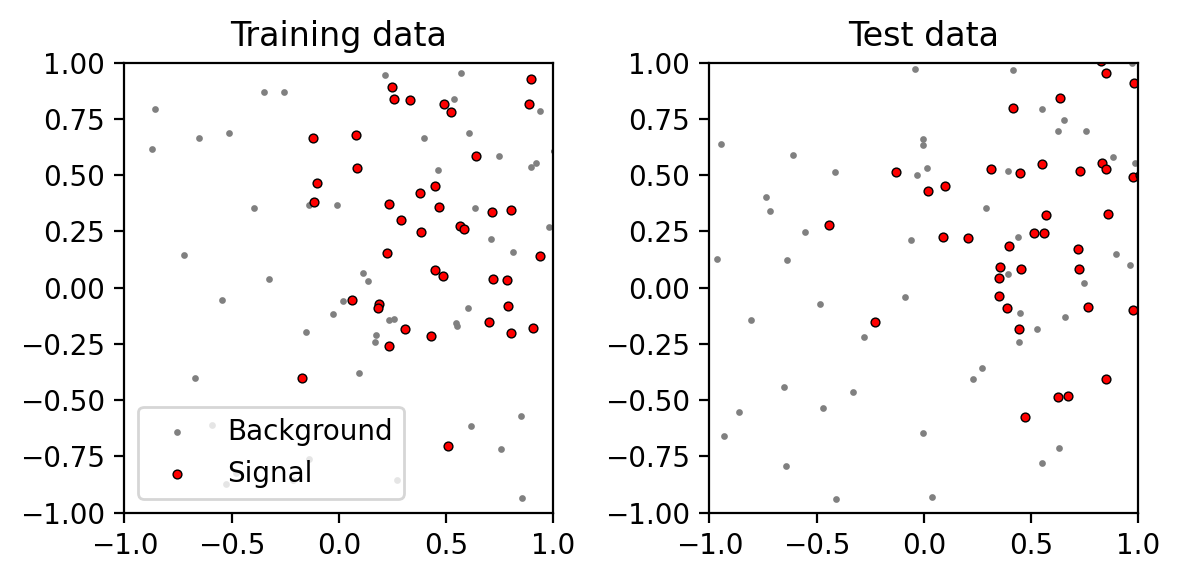

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax[0].scatter(bkg_points[:, 0], bkg_points[:, 1], s=2, c="gray", label="Background")
ax[0].scatter(
    signal_points[:, 0],
    signal_points[:, 1],
    s=10,
    c="red",
    ec="k",
    linewidth=0.5,
    label="Signal",
)
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].legend()
ax[0].set_title("Training data")


ax[1].scatter(
    test_bkg_points[:, 0], test_bkg_points[:, 1], s=2, c="gray", label="Background"
)
ax[1].scatter(
    test_signal_points[:, 0],
    test_signal_points[:, 1],
    s=10,
    c="red",
    ec="k",
    linewidth=0.5,
    label="Signal",
)
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_title("Test data")

plt.tight_layout()
plt.show()

In [32]:
X = torch.FloatTensor(np.concatenate((signal_points, bkg_points)))
Y = torch.FloatTensor(
    np.concatenate((np.ones(len(signal_points)), np.zeros(len(bkg_points))))
).unsqueeze(1)

train_dataset = TensorDataset(X, Y)

X_test = torch.FloatTensor(np.concatenate((test_signal_points, test_bkg_points)))
Y_test = torch.FloatTensor(
    np.concatenate((np.ones(len(test_signal_points)), np.zeros(len(test_bkg_points))))
).unsqueeze(1)

test_dataset = TensorDataset(X_test, Y_test)

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=100)
test_dataloader = DataLoader(test_dataset, batch_size=100)

In [34]:
class SimpleNet(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layer1 = nn.Linear(2, layer_sizes[0])
        for hidden_i in range(1, len(layer_sizes)):
            self.layers.append(
                nn.Linear(layer_sizes[hidden_i - 1], layer_sizes[hidden_i])
            )
        self.layer2 = nn.Linear(layer_sizes[-1], 1)
        self.activation = nn.ReLU()

    def forward(self, x):

        out = self.layer1(x)
        out = self.activation(out)
        for layer in self.layers:
            out = layer(out)
            out = self.activation(out)
        out = self.layer2(out)
        return out

In [35]:
net = SimpleNet([220] * 15)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_func = nn.BCEWithLogitsLoss()

In [36]:
loss_vs_epoch = []
n_epochs = 500

for epoch in tqdm(range(n_epochs)):
    loss_vs_epoch.append(
        [
            train_one_epoch(net, optimizer, train_dataloader),
            test_loss(net, test_dataloader),
        ]
    )

100%|██████████| 500/500 [00:23<00:00, 21.20it/s]


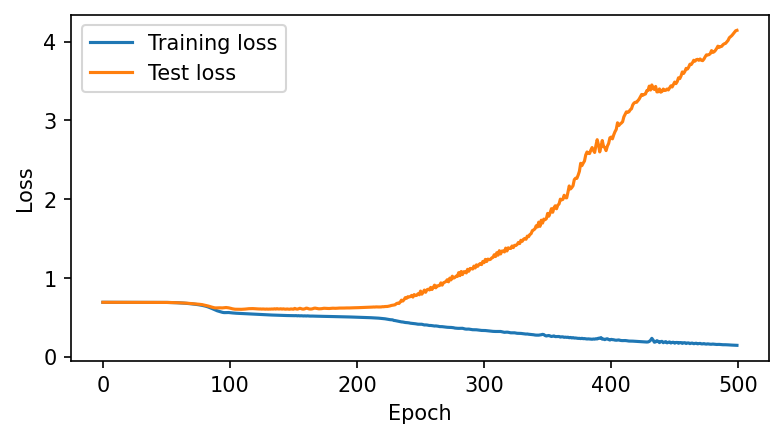

In [37]:
loss_vs_epoch = np.array(loss_vs_epoch)

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
ax.plot(loss_vs_epoch[:, 0], label="Training loss")
ax.plot(loss_vs_epoch[:, 1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

## We faced overfitting, so we need to add regularization

### How to do this? With dropout!

A new hyperparameter is introduced that specifies the probability at which outputs of the layer are dropped out, or inversely, the probability at which outputs of the layer are retained.

In [38]:
dropout = nn.Dropout(0.3)

During training, randomly zeroes some of the elements of the input tensor with probability $p = 0.3$ using samples from a Bernoulli distribution.\
Furthermore, the outputs are scaled by a factor of $\frac{1}{1-p}$ during training.

In [40]:
dropout.train()
x = torch.ones(10)
print("x:", x)
print("dropout(x):", dropout(x))

x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
dropout(x): tensor([0.0000, 1.4286, 1.4286, 1.4286, 1.4286, 0.0000, 0.0000, 1.4286, 1.4286,
        0.0000])


In [41]:
# During the evalutaion it is an identity function
dropout.eval()
print("x:", x)
print(dropout(x))

x: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [42]:
class DropoutNet(nn.Module):
    def __init__(self, layer_sizes, p=0.3):
        super().__init__()
        self.layers = nn.ModuleList()
        self.p = p
        self.layer1 = nn.Linear(2, layer_sizes[0])
        for hidden_i in range(1, len(layer_sizes)):
            self.layers.append(
                nn.Linear(layer_sizes[hidden_i - 1], layer_sizes[hidden_i])
            )
        self.layer2 = nn.Linear(layer_sizes[-1], 1)
        self.activation = nn.ReLU()
        if self.p > 0:
            self.dropout = nn.Dropout(p)

    def forward(self, x):

        out = self.layer1(x)
        out = self.activation(out)
        if self.p > 0:
            out = self.dropout(out)
        for layer in self.layers:
            out = layer(out)
            out = self.activation(out)
            if self.p > 0:
                out = self.dropout(out)
        out = self.layer2(out)
        return out

In [43]:
net = SimpleNet([300] * 10)
optimizer = torch.optim.Adam(net.parameters(), lr=1.2 * 1e-4)

net_with_dropout = DropoutNet([300] * 10, p=0.5)
optimizer_with_dropout = torch.optim.Adam(net_with_dropout.parameters(), lr=1.2 * 1e-4)

loss_func = nn.BCEWithLogitsLoss()

In [44]:
loss_vs_epoch = []
loss_vs_epoch_with_dropout = []
n_epochs = 500

for epoch in tqdm(range(n_epochs)):
    loss_vs_epoch.append(
        [
            train_one_epoch(net, optimizer, train_dataloader),
            test_loss(net, test_dataloader),
        ]
    )
    loss_vs_epoch_with_dropout.append(
        [
            train_one_epoch(net_with_dropout, optimizer_with_dropout, train_dataloader),
            test_loss(net_with_dropout, test_dataloader),
        ]
    )

100%|██████████| 500/500 [00:36<00:00, 13.55it/s]


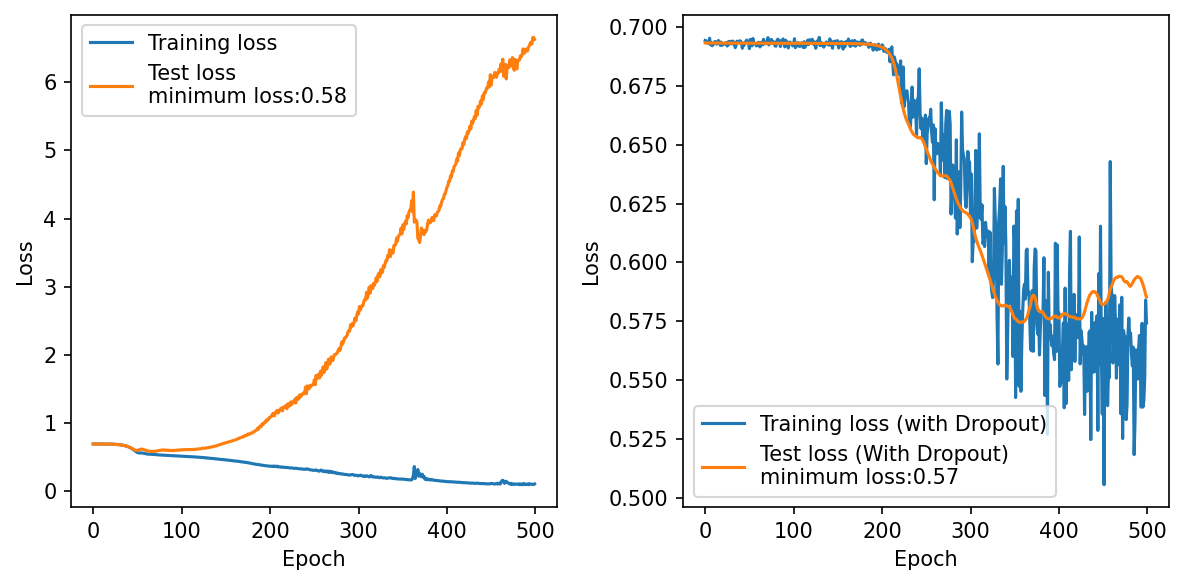

In [45]:
loss_vs_epoch = np.array(loss_vs_epoch)
loss_vs_epoch_with_dropout = np.array(loss_vs_epoch_with_dropout)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
ax[0].plot(loss_vs_epoch[:, 0], label="Training loss")
ax[0].plot(
    loss_vs_epoch[:, 1],
    label="Test loss\nminimum loss:{0:.2f}".format(np.min(loss_vs_epoch[:, 1])),
)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(loss_vs_epoch_with_dropout[:, 0], label="Training loss (with Dropout)")
ax[1].plot(
    loss_vs_epoch_with_dropout[:, 1],
    label="Test loss (With Dropout)\nminimum loss:{0:.2f}".format(
        np.min(loss_vs_epoch_with_dropout[:, 1])
    ),
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()

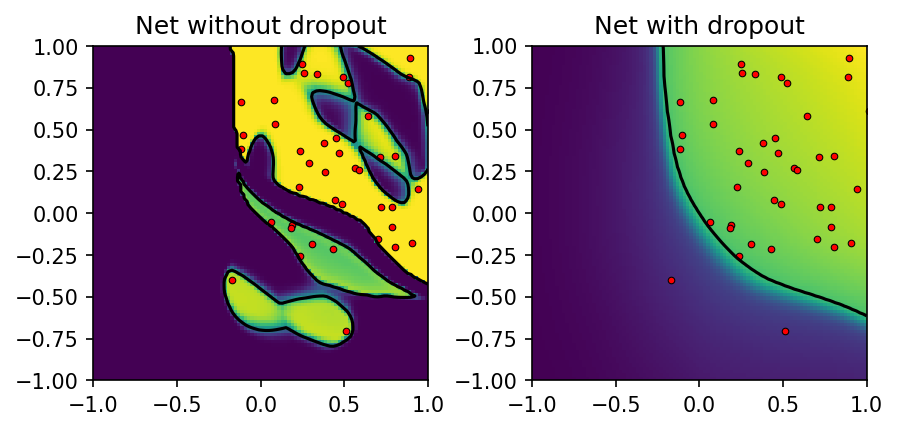

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=150)


sigmoid = nn.Sigmoid()

grid_resolution = 100
x1, x2 = np.meshgrid(
    np.linspace(-1, 1, grid_resolution), np.linspace(-1, 1, grid_resolution)
)

x1 = x1.reshape(-1)
x2 = x2.reshape(-1)
inputs = torch.FloatTensor(np.column_stack((x1, x2)))

x1, x2 = np.meshgrid(
    np.linspace(-1, 1, grid_resolution), np.linspace(-1, 1, grid_resolution)
)


def get_net_pred(nn):
    nn.eval()
    prediction = nn(inputs)
    net_prediction = (
        sigmoid(prediction).data.numpy().reshape(grid_resolution, grid_resolution)
    )
    return net_prediction


ax[0].imshow(get_net_pred(net), extent=(-1, 1, -1, 1), origin="lower")
ax[0].contour(
    x1, x2, get_net_pred(net), [0.5], colors="k", extent=(-1, 1, -1, 1), origin="lower"
)
ax[0].scatter(
    signal_points[:, 0], signal_points[:, 1], s=10, c="red", ec="k", linewidth=0.5
)
ax[0].set_title("Net without dropout")

ax[1].imshow(get_net_pred(net_with_dropout), extent=(-1, 1, -1, 1), origin="lower")
ax[1].contour(
    x1,
    x2,
    get_net_pred(net_with_dropout),
    [0.5],
    colors="k",
    extent=(-1, 1, -1, 1),
    origin="lower",
)
ax[1].scatter(
    signal_points[:, 0], signal_points[:, 1], s=10, c="red", ec="k", linewidth=0.5
)
ax[1].set_title("Net with dropout")

for i in range(2):
    ax[i].set_xlim(-1, 1)
    ax[i].set_ylim(-1, 1)

plt.tight_layout()
plt.show()